In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_original = pd.read_csv("données sans doublon.csv")
df = df_original[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']]

df = df[df['charges'] < 49000]

display(df)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


___
MODELE AVEC PIPELINE
___

In [58]:
df_original = pd.read_csv("data_cleaned_cheated.csv")
df = df_original[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'charges_group_cheat','bmi_category']]

# df.loc[:, 'charges_group'] = np.where(df['smoker'] == 0, 1,
#                                       np.where(df['bmi'] >= 30, 3,
#                                                np.where(df['sex'] == 0, 2,
#                                                         np.where(df['age'] < 22, 1, 3))))
df.loc[:, 'charges_group'] = np.where(df['smoker'] == 0, 1,
                                      np.where(df['bmi'] >= 30, 3,
                                               2))
df['have_children'] = np.where(df['children'] > 0, 1, 0)

# nettoyage
df = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'charges_group', 'have_children','bmi_category']]

display(df.head())

,age,sex,bmi,children,smoker,region,charges,charges_group,have_children,bmi_category
0,19,1,27.900,0,1,southwest,16884.92400,2,0,Surpoids
1,18,0,33.770,1,0,southeast,1725.55230,1,1,Obésité modérée
2,28,0,33.000,3,0,southeast,4449.46200,1,1,Obésité modérée
3,33,0,22.705,0,0,northwest,21984.47061,1,0,Poids normal
4,32,0,28.880,0,0,northwest,3866.85520,1,0,Surpoids


In [59]:
from sklearn.model_selection import train_test_split # pour diviser le jeu de données initial en 1 jeu d'entrainement (X_train, y_train) et un jeu de test (X_test, y_test)
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.preprocessing import PolynomialFeatures
import joblib
from statsmodels.formula.api import ols
import statsmodels.api as sm

df = pd.read_csv("données sans doublon.csv")

y = df[['charges']]

X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
# X['smoker_bmi'] = X['smoker'] * X['bmi']
# X['smoker_age'] = X['smoker'] * X['age']
# X['smoker_children'] = X['smoker'] * X['children']
# display(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

numerical_features = make_column_selector(dtype_include=np.number) # plutôt que : numerical_features = ['age', 'bmi', 'children']
categorical_features = make_column_selector(dtype_exclude=np.number) # plutôt que : categorical_features = ['region']

numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='if_binary'))

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                       (categorical_pipeline, categorical_features))

preprocessor = make_pipeline(preprocessor, PolynomialFeatures())

print("##################################################")
print("##################################################")
print("##################################################")
# AVEC GRID SEARCH
# Meilleurs hyperparamètres :  {'lassocv__alphas': [2, 1, 1, 1, 1, 1, 1, 1], 'lassocv__cv': 3, 'lassocv__eps': 0.1, 'lassocv__n_alphas': 100, 'lassocv__random_state': 42}
# 'lassocv__cv': 3, 'lassocv__eps': 0.1, 'lassocv__n_alphas': 100, 'lassocv__random_state': 42}

model = make_pipeline(preprocessor, LassoCV(alphas=[2, 1, 1, 1, 1, 1, 1, 1], cv=3, eps=0.1, n_alphas=100, random_state=42))
model.fit(X_train, y_train)
print("Avec GRID >", round(model.score(X_test, y_test)*100, 2))
model = make_pipeline(preprocessor, LassoCV(random_state=42))

# SANS GRID SEARCH
model.fit(X_train, y_train)
print("Premier modèle >", round(model.score(X_test, y_test)*100, 2))

# sauvegarde du meilleur modèle
joblib.dump(model, "model.sav")

# distance de cook
n = X_train.shape[0]
p = X_train.shape[1]

X_transformed = preprocessor.fit_transform(X_train)
col_name = preprocessor.get_feature_names_out()

X_transformed = pd.DataFrame(data=X_transformed, columns=col_name, index=y_train.index)

X_s = sm.add_constant(X_transformed)
model = sm.OLS(y_train, X_s)
results = model.fit()
display(results.summary())





# GRID SEARCH
if True == False:
    param_grid = {
        'lassocv__eps': [10**-x for x in range(1,6)],
        'lassocv__n_alphas': [100 * x for x in range(1,4)],
        'lassocv__alphas': [[1,1,1,1,1,1,1,1],
                            [2,1,1,1,1,1,1,1],
                            [1,2,1,1,1,1,1,1],
                            [1,1,2,1,1,1,1,1],
                            [1,1,1,2,1,1,1,1],
                            [1,1,1,1,2,1,1,1],
                            [1,1,1,1,1,2,1,1],
                            [1,1,1,1,1,1,2,1],
                            [1,1,1,1,1,1,1,2]],
        'lassocv__cv': [x for x in range(3,8)],
        'lassocv__random_state': [42]
    }
    grid_search = GridSearchCV(model, param_grid)
    # Entraînement du modèle avec recherche de grille
    grid_search.fit(X_train, y_train)

    print("Meilleurs hyperparamètres : ", grid_search.best_params_)
    # grid_search.predict(X_test))

##################################################
##################################################
##################################################
Avec GRID > 89.97


/home/utilisateur/Documents/projects/DEV_IA/insurance_premium_SC/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/utilisateur/Documents/projects/DEV_IA/insurance_premium_SC/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Premier modèle > 90.19


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     157.7
Date:                Mon, 15 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:53:39   Log-Likelihood:                -11260.
No. Observations:                1136   AIC:                         2.259e+04
Df Residuals:                    1099   BIC:                         2.278e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
1                                                          5592.3285    220.051     25.414      0.000    5160.561    6024.096
pipeline-1__age                                            2766.3144    183.253     15.096      0.000    2406.748    3125.881
pipeline-1__bmi                                              77.1767    190.445      0.405      0.685    -296.500     450.853
pipeline-1__children                                        954.6406    209.231      4.563      0.000     544.104    1365.177
pipeline-2__sex_male                                       -224.4392    148.028     -1.516      0.130    -514.890      66.011
pipeline-2__smoker_yes                                     1.085e+04    249.417     43.511      0.000    1.04e+04    1.13e+04
pipeline-2__region_northeast                               1925.9752    204.029      9.440      0.000    1525.645    2326.305
pipeline-2__region_northwest                               1353.3279    204.618      6.614      0.000     951.842    1754.814
pipeline-2__region_southeast                               1254.8188    202.101      6.209      0.000     858.272    1651.366
pipeline-2__region_southwest                               1058.2066    202.936      5.214      0.000     660.020    1456.393
pipeline-1__age^2                                           863.5898    183.376      4.709      0.000     503.783    1223.397
pipeline-1__age pipeline-1__bmi                              21.4271    158.868      0.135      0.893    -290.291     333.146
pipeline-1__age pipeline-1__children                        -39.7400    163.522     -0.243      0.808    -360.590     281.110
pipeline-1__age pipeline-2__sex_male                        232.6781    299.996      0.776      0.438    -355.952     821.308
pipeline-1__age pipeline-2__smoker_yes                     -151.9374    381.362     -0.398      0.690    -900.216     596.342
pipeline-1__age pipeline-2__region_northeast                208.0107    267.179      0.779      0.436    -316.227     732.249
pipeline-1__age pipeline-2__region_northwest                505.6107    275.444      1.836      0.067     -34.845    1046.066
pipeline-1__age pipeline-2__region_southeast               1187.6830    262.857      4.518      0.000     671.926    1703.440
pipeline-1__age pipeline-2__region_southwest                865.0100    273.137      3.167      0.002     329.082    1400.938
pipeline-1__bmi^2                                          -262.3667    124.452     -2.108      0.035    -506.557     -18.176
pipeline-1__bmi pipeline-1__children                          5.3518    157.504      0.034      0.973    -303.690     314.394
pipeline-1__bmi pipeline-2__sex_male                       

In [60]:
X_transformed

,1,pipeline-1__age,pipeline-1__bmi,pipeline-1__children,pipeline-2__sex_male,pipeline-2__smoker_yes,pipeline-2__region_northeast,pipeline-2__region_northwest,pipeline-2__region_southeast,pipeline-2__region_southwest,...,pipeline-2__region_northeast^2,pipeline-2__region_northeast pipeline-2__region_northwest,pipeline-2__region_northeast pipeline-2__region_southeast,pipeline-2__region_northeast pipeline-2__region_southwest,pipeline-2__region_northwest^2,pipeline-2__region_northwest pipeline-2__region_southeast,pipeline-2__region_northwest pipeline-2__region_southwest,pipeline-2__region_southeast^2,pipeline-2__region_southeast pipeline-2__region_southwest,pipeline-2__region_southwest^2
1094,1.0,-1.508889,0.086969,2.452595,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,1.0,1.766367,0.078750,0.768613,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
349,1.0,-1.437688,-0.490810,-0.915369,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
410,1.0,-1.437688,-2.192918,-0.915369,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
981,1.0,-0.583273,-0.808877,1.610604,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,1.0,0.413544,-1.552676,-0.915369,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
752,1.0,1.339160,-1.323372,-0.915369,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
319,1.0,-0.512072,1.070756,-0.073378,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
934,1.0,1.410361,-0.545876,-0.915369,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


0.0035211267605633804


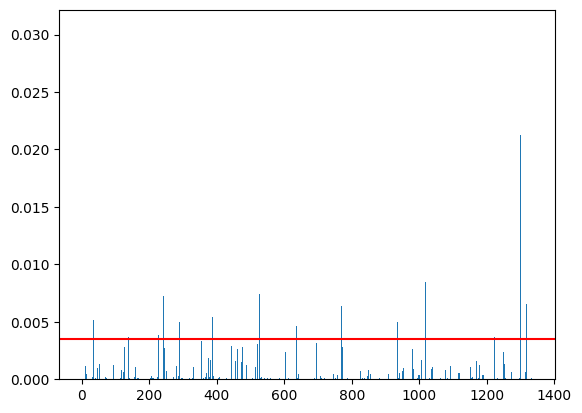

In [61]:
analyse = X_train.copy()
analyse['cook_distance'] = results.get_influence().cooks_distance[0]
analyse

plt.bar(analyse.index, analyse['cook_distance'])
plt.axhline(4/analyse.shape[0], color='red')

len(analyse[analyse['cook_distance'] > 0.0035])
print(4/analyse.shape[0])

In [66]:
X_train_cook = X_train[~(analyse['cook_distance'] > 4/analyse.shape[0])]
y_train_cook = y_train[~(analyse['cook_distance'] > 4/analyse.shape[0])]

# numerical_features = make_column_selector(dtype_include=np.number) # plutôt que : numerical_features = ['age', 'bmi', 'children']
# categorical_features = make_column_selector(dtype_exclude=np.number) # plutôt que : categorical_features = ['region']

# numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
# categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
#                                        (categorical_pipeline, categorical_features))


print("##################################################")
print("##################################################")
print("##################################################")
# AVEC GRID SEARCH
# Meilleurs hyperparamètres :  {'lassocv__alphas': [2, 1, 1, 1, 1, 1, 1, 1], 'lassocv__cv': 3, 'lassocv__eps': 0.1, 'lassocv__n_alphas': 100, 'lassocv__random_state': 42}
# 'lassocv__cv': 3, 'lassocv__eps': 0.1, 'lassocv__n_alphas': 100, 'lassocv__random_state': 42}

model = make_pipeline(preprocessor, LassoCV(alphas=[2, 1, 1, 1, 1, 1, 1, 1], cv=3, eps=0.1, n_alphas=100, random_state=42))
model.fit(X_train_cook, y_train_cook)
print("Avec GRID >", round(model.score(X_test, y_test)*100, 2))
model = make_pipeline(preprocessor, LassoCV(random_state=42))

# SANS GRID SEARCH
model.fit(X_train_cook, y_train_cook)
print("Premier modèle >", round(model.score(X_test, y_test)*100, 2))

data = [['19','female','27.9','0','yes','southwest']]
columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
df = pd.DataFrame(data, columns=columns)
print("prédiction >>>",model.predict(df))

# sauvegarde du meilleur modèle
joblib.dump(model, "model.sav")

##################################################
##################################################
##################################################
Avec GRID > 90.32


/home/utilisateur/Documents/projects/DEV_IA/insurance_premium_SC/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/utilisateur/Documents/projects/DEV_IA/insurance_premium_SC/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Premier modèle > 90.57
prédiction >>> [22467.8521349]


['model.sav']